In [132]:
%reset -f

In [133]:

import numpy as np
import math
import matplotlib.pyplot as plt
from casadi import *
from dataclasses import dataclass

In [148]:


@dataclass
class Parameters:
    # Time and discretization
    tf: float = 40        # final time [sec]
    nu: float = 40         # number of control intervals
    dut: float = tf / nu    # time step

    # Aircraft physical constants
    m: float = 4662                # mass [lb sec^2 / ft]
    g: float = 32.172              # gravity [ft/sec^2]
    delta: float = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0: float = 0.4456e5           # [lb]
    A1: float = -0.2398e2          # [lb sec / ft]
    A2: float = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho: float = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S: float = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0: float = 0.4             # initial beta value (approximate)
    beta_dot0: float = 0.2         # initial beta rate
    sigma: float = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0: float = 0.1552
    B1: float = 0.12369            # [1/rad]
    B2: float = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0: float = 0.7125             # baseline lift coefficient
    C1: float = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2: float = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax: float = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax: float = 0.3          # max angle of attack [rad]
    alpha_star: float = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a: float = 6e-8                 # x transition midpoint [ft]
    b: float = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c: float = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d: float = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e: float = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR: float = 1000               # reference altitude [ft]
    h_star: float = 1000           # used in some wind models

    # Auxiliary
    eps: float = 1e-6              # to avoid division by zero in V
    
    # objective
    q: int = 4


params = Parameters()
k_value = 1

def A_piecewise(x_):
    A1 = -50 + params.a * x_**3 + params.b * x_**4
    A2 = 0.025 * (x_ - 2300)
    A3 = 50 - params.a * (4600 - x_)**3 - params.b * (4600 - x_)**4
    A4 = 50
    return if_else(x_ <= 500, A1,
           if_else(x_ <= 4100, A2,
           if_else(x_ <= 4600, A3, A4)))

def B_piecewise(x_):
    B1 = params.d * x_**3 + params.e * x_**4
    B2 = -51 * exp(fmin(-params.c * (x_ - 2300)**4, 30))
    B3 = params.d * (4600 - x_)**3 + params.e * (4600 - x_)**4
    B4 = 0
    return if_else(x_ <= 500, B1,
           if_else(x_ <= 4100, B2,
           if_else(x_ <= 4600, B3, B4)))

def wind_x(x_, k_):
    return k_ * A_piecewise(x_)

def wind_h(x_, h_, k_):
    h_safe = fmax(h_, 10.0)
    return k_ * h_safe / params.h_star * B_piecewise(x_)


def C_L(alpha_):
    return if_else(alpha_ > params.alpha_star, params.C0 + params.C1 * alpha_,
                      params.C0 + params.C1 * alpha_ + params.C2 * (alpha_ - params.alpha_star)**2)
def beta(t_):
    return if_else(t_ < params.sigma, params.beta0 + params.beta_dot0 * t_, 1.0)

# Symbolic derivatives
x1 = SX.sym('x1')       # x
x2 = SX.sym('x2')       # h
x3 = SX.sym('x3')       # V
x4 = SX.sym('x4')       # gamma
x5 = SX.sym('x5')       # alpha
t = SX.sym('t')         # time
u = SX.sym('u')         # control
x = vertcat(x1,x2,x3,x4,x5)


Wx_expr = wind_x(x1, k_value)
Wh_expr = wind_h(x1, x2, k_value)
dWx_dx_fun = Function("dWx_dx", [x1], [gradient(Wx_expr, x1)])
dWh_dx_fun = Function("dWh_dx", [x1, x2], [gradient(Wh_expr, x1)])
dWh_dh_fun = Function("dWh_dh", [x1, x2], [gradient(Wh_expr, x2)])

    
def aircraft_ode(X, u_, t_):    
    x_, h_, V_, gamma_, alpha_ = vertsplit(X)
    T = beta(t_) * (params.A0 + params.A1 * V_ + params.A2 * V_**2)
    D = 0.5 * (params.B0 + params.B1 * alpha_ + params.B2 * alpha_**2) * params.rho * params.S * V_**2
    L = 0.5 * params.rho * params.S * C_L(alpha_) * V_**2
    Wx = wind_x(x_, k_value)
    Wh = wind_h(x_, h_, k_value)
    V_safe = fmax(V_, 1e-3)

    x_dot = V_ * cos(gamma_) + Wx
    h_dot = V_ * sin(gamma_) + Wh

    dWx_dx_val = dWx_dx_fun(x_)[0]
    dWh_dx_val = dWh_dx_fun(x_, h_)[0]
    dWh_dh_val = dWh_dh_fun(x_, h_)[0]

    Wx_dot = dWx_dx_val * x_dot
    Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

    V_dot = T / params.m * cos(alpha_ + params.delta) - D / params.m - params.g * sin(gamma_) - (Wx_dot * cos(gamma_) + Wh_dot * sin(gamma_))
    gamma_dot = T / (params.m * V_safe) * sin(alpha_ + params.delta) + L / (params.m * V_safe) - params.g / V_safe * cos(gamma_) + (1 / V_safe) * (Wx_dot * sin(gamma_) - Wh_dot * cos(gamma_))
    alpha_dot = u_

    return vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

def h_constriant_help(X, u_, t_):    
    x_, h_, V_, gamma_, alpha_ = vertsplit(X)
    T = beta(t_) * (params.A0 + params.A1 * V_ + params.A2 * V_**2)
    D = 0.5 * (params.B0 + params.B1 * alpha_ + params.B2 * alpha_**2) * params.rho * params.S * V_**2
    L = 0.5 * params.rho * params.S * C_L(alpha_) * V_**2
    Wx = wind_x(x_, k_value)
    Wh = wind_h(x_, h_, k_value)
    V_safe = fmax(V_, 1e-3)

    x_dot = V_ * cos(gamma_) + Wx
    h_dot = V_ * sin(gamma_) + Wh

    dWx_dx_val = dWx_dx_fun(x_)[0]
    dWh_dx_val = dWh_dx_fun(x_, h_)[0]
    dWh_dh_val = dWh_dh_fun(x_, h_)[0]

    Wx_dot = dWx_dx_val * x_dot
    Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

    V_dot = T / params.m * cos(alpha_ + params.delta) - D / params.m - params.g * sin(gamma_) - (Wx_dot * cos(gamma_) + Wh_dot * sin(gamma_))
    gamma_dot = T / (params.m * V_safe) * sin(alpha_ + params.delta) + L / (params.m * V_safe) - params.g / V_safe * cos(gamma_) + (1 / V_safe) * (Wx_dot * sin(gamma_) - Wh_dot * cos(gamma_))
    alpha_dot = u_
    
    h_ddot = V_dot*sin(gamma_) + V_*gamma_dot*cos(gamma_) + Wh_dot

    return h_ddot

def running_cost(xk):
    Q = (params.hR-xk[1])**params.q
    return Q

def rk4_step(f, xk, uk, tk, dt, qf, qk):
    k1 = f(xk, uk, tk)
    k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
    k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
    k4 = f(xk + dt * k3, uk, tk + dt)
    qk1 = qf(xk)
    qk2 = qf(xk + dt/2 * k1)
    qk3 = qf(xk + dt/2 * k2)
    qk4 = qf(xk + dt * k3)
    return {xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4), qk + dt/6 * (qk1 + 2*qk2 + 2*qk3 + qk4)}

def solve_ocp():
    # npl prep
    w = []    # List of decision variables
    w0 = []   # Initial guess
    lbw = []  # Lower bounds
    ubw = []  # Upper bounds
    g = []    # Constraints
    lbg = []  # Lower bound on constraints
    ubg = []  # Upper bound on constraints
    J = 0     # Objective function
    
    # Initial State Constraint
    x_initial = [0, 600, 239.7, -2.249*pi/180, 7.353*pi/180]
    Xk = MX.sym('X_0', 5)
    w += [Xk]
    lbw += x_initial
    ubw += x_initial
    w0 += x_initial
    
    Tk = 0
    
    # loop over control discretization
    for k in range(params.nu):
        # control
        Uk = MX.sym('U_' + str(k))
        w += [Uk]
        lbw += [-3*pi/180]
        ubw += [3*pi/180]
        w0 += [0]
        
        # state integration
        # f, xk, uk, tk, dt, qf, qk
        Xk_end, J_end = rk4_step(aircraft_ode, Xk, Uk, Tk, params.dut, running_cost, J)
        J = J_end
        h_ddot_val = h_constriant_help(Xk, Uk, Tk)
        
        Tk += params.dut
        
        # state
        Xk = MX.sym('X_' + str(k+1), 5)
        w += [Xk]
        lbw += [-inf, 0, -inf, -inf, -inf]
        ubw += [inf, params.hR, inf, inf, 17.2*pi/180]
        w0 += [k*10000/params.nu, 600, 239.7, -2.249*pi/180, 7.353*pi/180]
        g+= [Xk_end-Xk]
        lbg += [0, 0, 0, 0, 0]
        ubg += [0, 0, 0, 0, 0]
        
        # Add to constraint list
        g += [h_ddot_val]
        lbg += [-2 * params.g]
        ubg += [10 * params.g]
    
    XF = 7.431*pi/180
    g += [Xk[4] - XF]
    lbg += [0]
    ubg += [0] 
    
    opts = {
        'ipopt': {
            'print_level': 3,               # Verbosity: 0 (quiet) to 12 (very verbose)
        }
    }
    
    npl = {'x':vertcat(*w),'f':J, 'g':vertcat(*g)}
    solver = nlpsol('solver', 'ipopt', npl, opts)
    
    arg = {'x0':w0, 'lbx':lbw, 'ubx':ubw, 'lbg':lbg, 'ubg':ubg}
    
    # Solve
    sol = solver(**arg)
    w_opt = sol['x'].full().flatten()
    J_opt = sol['f'].full().flatten()
    
    return w_opt, J_opt


In [152]:
w_opt, J_opt = solve_ocp()

Total number of variables............................:      240
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       80
                     variables with only upper bounds:       40
Total number of equality constraints.................:      201
Total number of inequality constraints...............:       40
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       40
        inequality constraints with only upper bounds:        0


Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   1.4950682392390518e+04    1.4950682392390518e+12
Dual infeasibility......:   1.0288658813806251e-11    1.0288658813806251e-03
Constraint violation....:   9.0949470177292824e-13    9.0949470177292824e-13
Variable bound violation:   9.9999999947364415e-09    9.9999999947364415e-09
Complementari

Optimal cost J* = [1.49506824e+12]
496.35774541139943


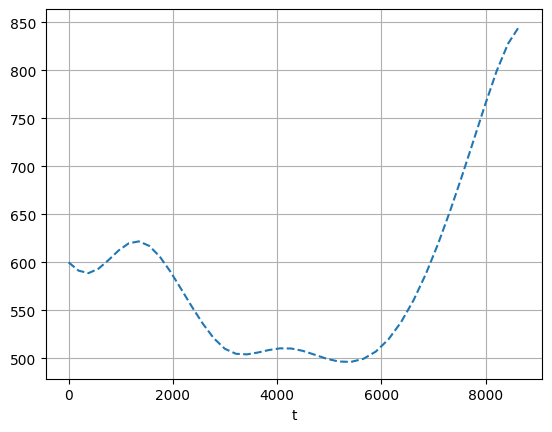

In [95]:
# plot
x1_opt = w_opt[0::6]    # start at index 0, get every 3rd:
x2_opt = w_opt[1::6]    # start at index 1, get every 3rd:
x3_opt = w_opt[2::6]    # start at index 1, get every 3rd:
x4_opt = w_opt[3::6]    # start at index 1, get every 3rd:
x5_opt = w_opt[4::6]    # start at index 1, get every 3rd:
u_opt = w_opt[5::6]     # start at index 2, get every 3rd:

tgrid = [params.tf/params.nu*k for k in range(params.nu+1)]

print("Optimal cost J* =", J_opt)
print(min(x2_opt))

plt.figure(1)
plt.clf()
plt.plot(x1_opt, x2_opt, '--')
plt.xlabel('t')
plt.grid()
plt.show()

# This should be Faster

- lower nu
- change to SX
- Se two diffrent plots (one more detailed reconstruction)
- for nu = 20, minimum height is similar, for nu= 10 it drops significantly

In [219]:
from casadi import *
from dataclasses import dataclass
import numpy as np

@dataclass
class Parameters:
    # Time and discretization
    tf: float = 40        # final time [sec]
    nu: float = 10         # number of control intervals
    dut: float = tf / nu    # time step

    # Aircraft physical constants
    m: float = 4662                # mass [lb sec^2 / ft]
    g: float = 32.172              # gravity [ft/sec^2]
    delta: float = 0.03491         # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0: float = 0.4456e5           # [lb]
    A1: float = -0.2398e2          # [lb sec / ft]
    A2: float = 0.1442e-1          # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho: float = 0.2203e-2         # air density [lb sec^2 / ft^4]
    S: float = 0.1560e4            # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0: float = 0.4             # initial beta value (approximate)
    beta_dot0: float = 0.2         # initial beta rate
    sigma: float = 3               # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0: float = 0.1552
    B1: float = 0.12369            # [1/rad]
    B2: float = 2.4203             # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0: float = 0.7125             # baseline lift coefficient
    C1: float = 6.0877             # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2: float = -9.0277            # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax: float = 0.05236          # max control input (rate of change of alpha) [rad/sec]
    alphamax: float = 0.3          # max angle of attack [rad]
    alpha_star: float = 0.20944    # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a: float = 6e-8                 # x transition midpoint [ft]
    b: float = -4e-11               # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c: float = -np.log(25/30.6)*1e-12      # transition smoothing width [ft]
    d: float = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
    e: float = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR: float = 1000               # reference altitude [ft]
    h_star: float = 1000           # used in some wind models

    # Auxiliary
    eps: float = 1e-6              # to avoid division by zero in V

    # objective
    q: int = 4


params = Parameters()
k_value = 1

def A_piecewise(x_):
    A1 = -50 + params.a * x_**3 + params.b * x_**4
    A2 = 0.025 * (x_ - 2300)
    A3 = 50 - params.a * (4600 - x_)**3 - params.b * (4600 - x_)**4
    A4 = 50
    return if_else(x_ <= 500, A1,
           if_else(x_ <= 4100, A2,
           if_else(x_ <= 4600, A3, A4)))

def B_piecewise(x_):
    B1 = params.d * x_**3 + params.e * x_**4
    B2 = -51 * exp(fmin(-params.c * (x_ - 2300)**4, 30))
    B3 = params.d * (4600 - x_)**3 + params.e * (4600 - x_)**4
    B4 = 0
    return if_else(x_ <= 500, B1,
           if_else(x_ <= 4100, B2,
           if_else(x_ <= 4600, B3, B4)))

def wind_x(x_, k_):
    return k_ * A_piecewise(x_)

def wind_h(x_, h_, k_):
    h_safe = fmax(h_, 10.0)
    return k_ * h_safe / params.h_star * B_piecewise(x_)

def C_L(alpha_):
    return if_else(alpha_ > params.alpha_star, params.C0 + params.C1 * alpha_,
                      params.C0 + params.C1 * alpha_ + params.C2 * (alpha_ - params.alpha_star)**2)

def beta(t_):
    return if_else(t_ < params.sigma, params.beta0 + params.beta_dot0 * t_, 1.0)

# Symbolic vars for derivatives
x1 = SX.sym('x1')       # x
x2 = SX.sym('x2')       # h
x3 = SX.sym('x3')       # V
x4 = SX.sym('x4')       # gamma
x5 = SX.sym('x5')       # alpha
t = SX.sym('t')         # time
u = SX.sym('u')         # control
x = vertcat(x1,x2,x3,x4,x5)

Wx_expr = wind_x(x1, k_value)
Wh_expr = wind_h(x1, x2, k_value)

dWx_dx_fun = Function("dWx_dx", [x1], [gradient(Wx_expr, x1)])
dWh_dx_fun = Function("dWh_dx", [x1, x2], [gradient(Wh_expr, x1)])
dWh_dh_fun = Function("dWh_dh", [x1, x2], [gradient(Wh_expr, x2)])


def aircraft_ode_and_hddot(X, u_, t_):
    x_, h_, V_, gamma_, alpha_ = vertsplit(X)
    T = beta(t_) * (params.A0 + params.A1 * V_ + params.A2 * V_**2)
    D = 0.5 * (params.B0 + params.B1 * alpha_ + params.B2 * alpha_**2) * params.rho * params.S * V_**2
    L = 0.5 * params.rho * params.S * C_L(alpha_) * V_**2
    Wx = wind_x(x_, k_value)
    Wh = wind_h(x_, h_, k_value)
    V_safe = fmax(V_, 1e-3)

    x_dot = V_ * cos(gamma_) + Wx
    h_dot = V_ * sin(gamma_) + Wh

    dWx_dx_val = dWx_dx_fun(x_)[0]
    dWh_dx_val = dWh_dx_fun(x_, h_)[0]
    dWh_dh_val = dWh_dh_fun(x_, h_)[0]

    Wx_dot = dWx_dx_val * x_dot
    Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

    V_dot = T / params.m * cos(alpha_ + params.delta) - D / params.m - params.g * sin(gamma_) - (Wx_dot * cos(gamma_) + Wh_dot * sin(gamma_))
    gamma_dot = T / (params.m * V_safe) * sin(alpha_ + params.delta) + L / (params.m * V_safe) - params.g / V_safe * cos(gamma_) + (1 / V_safe) * (Wx_dot * sin(gamma_) - Wh_dot * cos(gamma_))
    alpha_dot = u_

    h_ddot = V_dot*sin(gamma_) + V_*gamma_dot*cos(gamma_) + Wh_dot

    return vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot), h_ddot


def running_cost(xk):
    Q = (params.hR - xk[1])**params.q
    return Q


def rk4_step(f, xk, uk, tk, dt, qf, qk):
    k1, hdotdot = f(xk, uk, tk)
    k2, _ = f(xk + dt/2 * k1, uk, tk + dt/2)
    k3, _ = f(xk + dt/2 * k2, uk, tk + dt/2)
    k4, _ = f(xk + dt * k3, uk, tk + dt)
    qk1 = qf(xk)
    qk2 = qf(xk + dt/2 * k1)
    qk3 = qf(xk + dt/2 * k2)
    qk4 = qf(xk + dt * k3)
    return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4), qk + dt/6 * (qk1 + 2*qk2 + 2*qk3 + qk4), hdotdot


def solve_ocp():
    w = []
    w0 = []
    lbw = []
    ubw = []
    g = []
    lbg = []
    ubg = []
    J = 0

    # Initial State Constraint
    x_initial = [0, 600, 239.7, -2.249*pi/180, 7.353*pi/180]
    Xk = MX.sym('X_0', 5)
    w += [Xk]
    lbw += x_initial
    ubw += x_initial
    w0 += x_initial

    Tk = 0

    for k in range(params.nu):
        Uk = MX.sym('U_' + str(k))
        w += [Uk]
        lbw += [-3*pi/180]
        ubw += [3*pi/180]
        w0 += [0]

        Xk_end, J_end, h_ddot_val = rk4_step(aircraft_ode_and_hddot, Xk, Uk, Tk, params.dut, running_cost, J)
        J = J_end

        # Get h_ddot for constraints separately

        Tk += params.dut

        Xk = MX.sym('X_' + str(k+1), 5)
        w += [Xk]
        lbw += [-inf, 0, -inf, -inf, -inf]
        ubw += [inf, params.hR, inf, inf, 17.2*pi/180]
        w0 += [k*10000/params.nu, 600, 239.7, -2.249*pi/180, 7.353*pi/180]

        g += [Xk_end - Xk]
        lbg += [0, 0, 0, 0, 0]
        ubg += [0, 0, 0, 0, 0]

        g += [h_ddot_val]
        lbg += [-2 * params.g]
        ubg += [10 * params.g]

    XF = 7.431*pi/180
    g += [Xk[4] - XF]
    lbg += [0]
    ubg += [0]

    opts = {'ipopt': {'print_level': 3}}
    nlp = {'x': vertcat(*w), 'f': J, 'g': vertcat(*g)}
    solver = nlpsol('solver', 'ipopt', nlp, opts)
    arg = {'x0': w0, 'lbx': lbw, 'ubx': ubw, 'lbg': lbg, 'ubg': ubg}

    sol = solver(**arg)
    w_opt = sol['x'].full().flatten()
    J_opt = sol['f'].full().flatten()

    return w_opt, J_opt


In [220]:
w_opt, J_opt = solve_ocp()

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:       10
Total number of equality constraints.................:       51
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0


Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   1.5159418847796194e+04    1.5159418847796194e+12
Dual infeasibility......:   3.1072632533491994e-11    3.1072632533491996e-03
Constraint violation....:   4.3967839286928881e-13    1.8189894035458565e-12
Variable bound violation:   9.9999999947364415e-09    9.9999999947364415e-09
Complementari

Optimal cost J* = [1.51594188e+12]
492.9821810261484


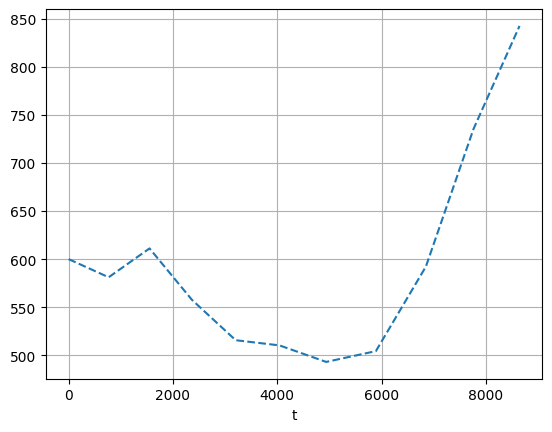

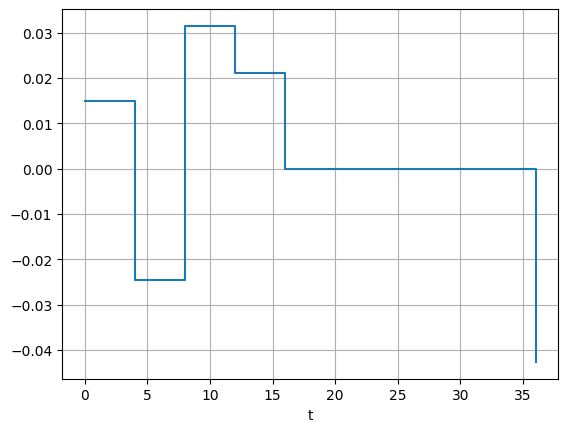

In [221]:
# Plot
# Result directly from IPOPT
x1_opt = w_opt[0::6]    # start at index 0, get every 6th:
x2_opt = w_opt[1::6]   
x3_opt = w_opt[2::6]  
x4_opt = w_opt[3::6] 
x5_opt = w_opt[4::6]
u_opt = w_opt[5::6]

tgrid = [params.tf/params.nu*k for k in range(params.nu+1)]

print("Optimal cost J* =", J_opt)
print(min(x2_opt))

plt.figure(1)
plt.clf()
plt.plot(x1_opt, x2_opt, '--')
plt.xlabel('t')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
plt.step(tgrid[:-1], u_opt, where='post')
plt.xlabel('t')
plt.grid()
plt.show()

Optimal cost J* = 1.53381e+12
Minimum altitude: 483.44759801204356


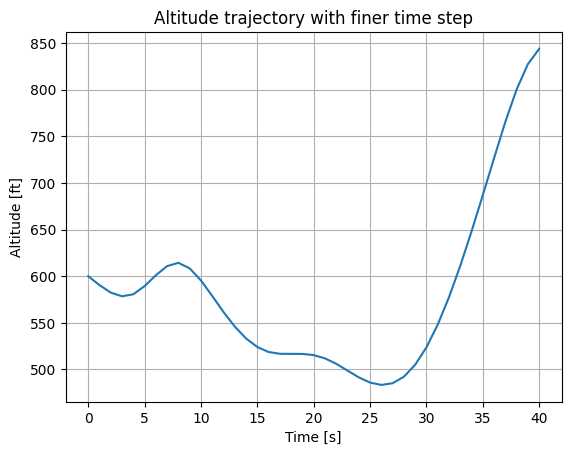

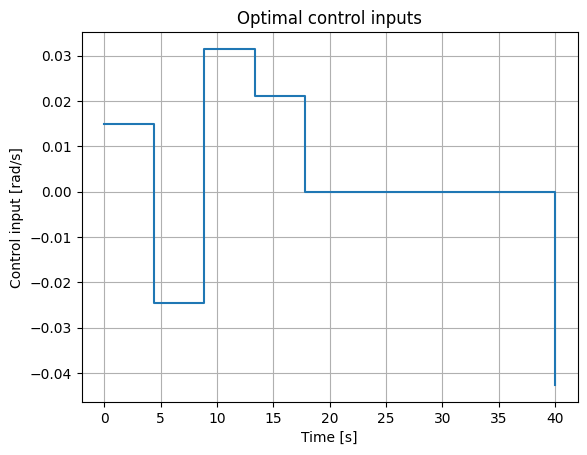

In [222]:
# Plot
# reconstruction with smaller time step

u_long = []
multiple = 4
for k in range(params.nu):
    for i in range(multiple):
        u_long.append(u_opt[k])

x_initial = [0, 600, 239.7, -2.249*np.pi/180, 7.353*np.pi/180]

X = []
X.append(x_initial)
J = 0
Tk = 0
dt = params.tf / (params.nu * multiple)

for k in range(params.nu * multiple):
    Xk, J, _ = rk4_step(aircraft_ode_and_hddot, X[-1], u_long[k], Tk, dt, running_cost, J)
    Tk += dt
    X.append(Xk.full().flatten())

# Convert X to NumPy array for easier slicing
X = np.array(X)  # shape: (num_steps+1, state_dim)

# Now extract state variables:
x1_opt = X[:, 0]
x2_opt = X[:, 1]
x3_opt = X[:, 2]
x4_opt = X[:, 3]
x5_opt = X[:, 4]

tgrid_fine = np.linspace(0, params.tf, params.nu * multiple + 1)

print("Optimal cost J* =", J)
print("Minimum altitude:", np.min(x2_opt))

# Plot altitude vs time
plt.figure()
plt.plot(tgrid_fine, x2_opt)
plt.xlabel('Time [s]')
plt.ylabel('Altitude [ft]')
plt.title('Altitude trajectory with finer time step')
plt.grid(True)
plt.show()

# Plot control inputs over original grid
tgrid_coarse = np.linspace(0, params.tf, params.nu)
plt.figure()
plt.step(tgrid_coarse, u_opt, where='post')
plt.xlabel('Time [s]')
plt.ylabel('Control input [rad/s]')
plt.title('Optimal control inputs')
plt.grid(True)
plt.show()
